In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [96]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [9]:
df_nifty = pd.read_csv("NSE.csv")

In [10]:
df_nifty.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Mar-2020,11387.35,11433.00,11036.25,11132.75,681148567,24204.55
1,03-Mar-2020,11217.55,11342.25,11152.55,11303.30,696919348,23281.20
2,04-Mar-2020,11351.35,11356.60,11082.15,11251.00,798021596,26928.46
3,05-Mar-2020,11306.05,11389.50,11244.60,11269.00,1353209029,26980.65
4,06-Mar-2020,10942.65,11035.10,10827.40,10989.45,1811564187,26455.29


In [11]:
df_nifty["Date"] = pd.to_datetime(df_nifty['Date'])

In [12]:
df_nifty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               249 non-null    datetime64[ns]
 1   Open               249 non-null    float64       
 2   High               249 non-null    float64       
 3   Low                249 non-null    float64       
 4   Close              249 non-null    float64       
 5   Shares Traded      249 non-null    int64         
 6   Turnover (Rs. Cr)  249 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.7 KB


In [13]:
df.head()

NameError: name 'df' is not defined

In [152]:
df.isnull().any().any()

False

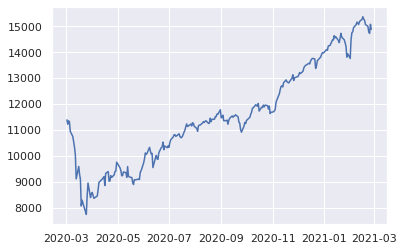

In [153]:
plt.plot(df["Date"], df["Open"])

In [154]:
df_bse = pd.read_csv("CSVForDate.csv", index_col=False)

In [156]:
df_bse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    300 non-null    object 
 1   Open    300 non-null    float64
 2   High    300 non-null    float64
 3   Low     300 non-null    float64
 4   Close   300 non-null    float64
dtypes: float64(4), object(1)
memory usage: 11.8+ KB


In [157]:
df_bse.head()

,Date,Open,High,Low,Close
0,1-February-2020,40753.18,40905.78,39631.24,39735.53
1,3-February-2020,39701.02,40014.90,39563.07,39872.31
2,4-February-2020,40178.74,40818.94,40117.46,40789.38
3,5-February-2020,40921.71,41177.00,40703.32,41142.66
4,6-February-2020,41209.13,41405.43,41113.11,41306.03


In [158]:
df_bse["Date"] = pd.to_datetime(df_bse['Date'])

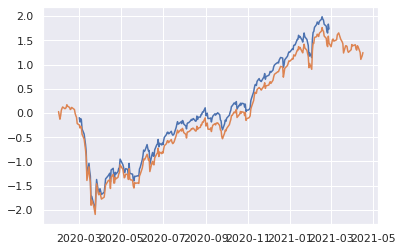

In [159]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc2 = StandardScaler()
plt.plot(df["Date"], sc2.fit_transform(np.array(df_nifty["Open"]).reshape(-1, 1)))
plt.plot(df_bse["Date"],sc.fit_transform(np.array(df_bse["Open"]).reshape(-1, 1)))

In [3]:
df_owid = pd.read_csv("India_OWID_reduced.csv")

In [4]:
df_owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       438 non-null    int64  
 1   location                         438 non-null    object 
 2   date                             438 non-null    object 
 3   total_cases                      438 non-null    float64
 4   new_cases                        438 non-null    float64
 5   new_cases_smoothed               433 non-null    float64
 6   total_deaths                     397 non-null    float64
 7   new_deaths                       397 non-null    float64
 8   new_deaths_smoothed              433 non-null    float64
 9   total_cases_per_million          438 non-null    float64
 10  new_cases_per_million            438 non-null    float64
 11  new_cases_smoothed_per_million   433 non-null    float64
 12  total_deaths_per_milli

In [5]:
df_owid = df_owid.dropna()
df_owid.shape

(367, 26)

In [6]:
print(df_owid.shape)
df_owid.head()

(367, 26)


,Unnamed: 0,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,handwashing_facilities,hospital_beds_per_thousand
50,33321,India,2020-03-20,244.0,50.0,23.143,5.0,1.0,0.429,0.177,...,14376.0,0.010,0.001,1125.0,0.001,0.021,48.6,samples tested,59.55,0.53
51,33322,India,2020-03-21,330.0,86.0,32.571,4.0,-1.0,0.286,0.239,...,15701.0,0.011,0.001,1125.0,0.001,0.029,34.5,samples tested,59.55,0.53
52,33323,India,2020-03-22,396.0,66.0,40.429,7.0,3.0,0.714,0.287,...,16999.0,0.012,0.001,1121.0,0.001,0.036,27.7,samples tested,59.55,0.53
53,33324,India,2020-03-23,499.0,103.0,54.286,10.0,3.0,1.143,0.362,...,20707.0,0.015,0.003,1462.0,0.001,0.037,26.9,samples tested,59.55,0.53
54,33325,India,2020-03-24,536.0,37.0,56.286,10.0,0.0,1.000,0.388,...,20864.0,0.015,0.000,1295.0,0.001,0.043,23.0,samples tested,59.55,0.53


In [7]:
df_owid["Date"] = df_owid["date"]
df_owid = df_owid.drop(["Unnamed: 0", "date", "tests_units"], axis=1) # REMOVE ALL CORRELATED FEATURES

In [8]:
df_owid["Date"] = pd.to_datetime(df_owid['Date'])

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,02-Mar-2020,11387.35,11433.00,11036.25,11132.75,681148567,24204.55
1,03-Mar-2020,11217.55,11342.25,11152.55,11303.30,696919348,23281.20
2,04-Mar-2020,11351.35,11356.60,11082.15,11251.00,798021596,26928.46
3,05-Mar-2020,11306.05,11389.50,11244.60,11269.00,1353209029,26980.65
4,06-Mar-2020,10942.65,11035.10,10827.40,10989.45,1811564187,26455.29
...,...,...,...,...,...,...,...
244,22-Feb-2021,14999.05,15010.10,14635.05,14675.70,609898454,37578.07
245,23-Feb-2021,14782.25,14854.50,14651.85,14707.80,744092809,39508.09
246,24-Feb-2021,14729.15,15008.80,14723.05,14982.00,403754669,23723.99
247,25-Feb-2021,15079.85,15176.50,15065.35,15097.35,803883875,42983.07


In [14]:
df_merged = pd.merge(df_nifty, df_owid, how="outer", on=["Date"])
df_merged = df_merged.dropna()
df_merged.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),location,total_cases,new_cases,...,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,handwashing_facilities,hospital_beds_per_thousand
13,2020-03-20,8284.45,8883.00,8178.20,8745.45,1.072264e+09,37321.25,India,244.0,50.0,...,1060.0,14376.0,0.010,0.001,1125.0,0.001,0.021,48.6,59.55,0.53
14,2020-03-23,7945.70,8159.25,7583.60,7610.25,6.541518e+08,23891.90,India,499.0,103.0,...,3708.0,20707.0,0.015,0.003,1462.0,0.001,0.037,26.9,59.55,0.53
15,2020-03-24,7848.30,8036.95,7511.10,7801.05,7.393544e+08,28282.09,India,536.0,37.0,...,157.0,20864.0,0.015,0.000,1295.0,0.001,0.043,23.0,59.55,0.53
16,2020-03-25,7735.15,8376.75,7714.75,8317.85,7.381147e+08,28482.01,India,657.0,121.0,...,4280.0,25144.0,0.018,0.003,1717.0,0.001,0.042,24.0,59.55,0.53
22,2020-04-03,8356.55,8356.55,8055.80,8083.80,6.977524e+08,26561.18,India,2567.0,24.0,...,21294.0,69245.0,0.050,0.015,5937.0,0.004,0.040,24.7,59.55,0.53


In [15]:
df_merged = df_merged.drop(["High", "Low","total_cases","new_cases_smoothed", "total_deaths","Open","new_deaths_smoothed", "location", "total_cases_per_million", "new_cases_per_million", "new_cases_smoothed_per_million", "total_deaths_per_million", "new_deaths_per_million","new_deaths_smoothed_per_million", "total_tests", "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed"	,"new_tests_smoothed_per_thousand" ], axis=1)

In [16]:
# df_merged = df_merged.drop(["tests_units", "Unnamed: 0"], axis=1)
df_merged.head()

,Date,Close,Shares Traded,Turnover (Rs. Cr),new_cases,new_deaths,new_tests,positive_rate,tests_per_case,handwashing_facilities,hospital_beds_per_thousand
13,2020-03-20,8745.45,1.072264e+09,37321.25,50.0,1.0,1060.0,0.021,48.6,59.55,0.53
14,2020-03-23,7610.25,6.541518e+08,23891.90,103.0,3.0,3708.0,0.037,26.9,59.55,0.53
15,2020-03-24,7801.05,7.393544e+08,28282.09,37.0,0.0,157.0,0.043,23.0,59.55,0.53
16,2020-03-25,8317.85,7.381147e+08,28482.01,121.0,2.0,4280.0,0.042,24.0,59.55,0.53
22,2020-04-03,8083.80,6.977524e+08,26561.18,24.0,0.0,21294.0,0.040,24.7,59.55,0.53


In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [18]:
df_new = df_merged.drop("Date", axis=1)

In [19]:
df_new[df_new.columns] = scaler.fit_transform(df_new[df_new.columns])

In [20]:
df_new["Date"] = df_merged["Date"]
df_new.head()

,Close,Shares Traded,Turnover (Rs. Cr),new_cases,new_deaths,new_tests,positive_rate,tests_per_case,handwashing_facilities,hospital_beds_per_thousand,Date
13,0.147343,0.763019,0.438161,0.000511,0.000499,0.000605,0.045455,0.753704,0.0,0.0,2020-03-20
14,0.000000,0.432213,0.255034,0.001052,0.001498,0.002380,0.190909,0.351852,0.0,0.0,2020-03-23
15,0.024765,0.499625,0.314900,0.000378,0.000000,0.000000,0.245455,0.279630,0.0,0.0,2020-03-24
16,0.091843,0.498644,0.317626,0.001236,0.000999,0.002763,0.236364,0.298148,0.0,0.0,2020-03-25
22,0.061464,0.466710,0.291433,0.000245,0.000000,0.014164,0.218182,0.311111,0.0,0.0,2020-04-03


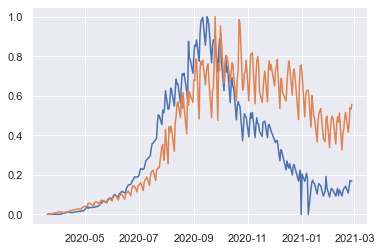

In [21]:
# plt.plot(df_merged["Date"], df_merged["Open"])
plt.plot(df_new["Date"], df_new["new_cases"])
plt.plot(df_new["Date"], df_new["new_tests"])
# plt.plot(df_new["Date"], df_new["Open"])

In [119]:
def sliding_window(data, seq_len):

    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len)].drop(["Date","location","date"], axis=1).to_numpy().flatten()
        y = data[(i+seq_len):i+seq_len+1]["new_cases"].to_numpy()[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs), np.array(ys)

In [27]:
X_train, y_train = sliding_window(df_new, 4)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_train.shape, y_train.shape

(torch.Size([221, 40]), torch.Size([221]))

In [28]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [34]:
def train_model(
        model, 
        train_data, 
        train_labels, 
        test_data=None, 
        test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()

        y_pred = model(X_train)

        loss = loss_fn(y_pred.float().flatten(), y_train)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
                test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

In [35]:
model = CoronaVirusPredictor(
  n_features=10, 
  n_hidden=50, 
  seq_len=4, 
  n_layers=2
)
# print(X_train.shape, y_train.reshape(219,1).shape)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train
)

Epoch 0 train loss: 53.61003494262695
Epoch 10 train loss: 20.5548152923584
Epoch 20 train loss: 17.882028579711914
Epoch 30 train loss: 17.270587921142578
Epoch 40 train loss: 17.26002311706543
Epoch 50 train loss: 16.298446655273438


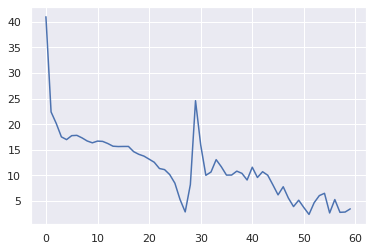

In [198]:
plt.plot(train_hist) # Training MSE Loss

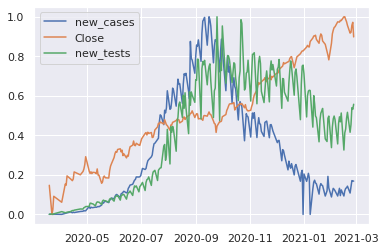

In [199]:
compare(df_new, ["new_cases", "Close", "new_tests"])

In [87]:
mobility = pd.read_csv("India_OWID_with_mobility_data.csv")

In [88]:
cols_nas = dict(zip(mobility.columns, mobility.isnull().sum(axis=0).tolist()))
to_drop = [key for key,value in cols_nas.items() if value > 20]#.any().any()#.dropna(axis=0)

In [89]:
columns_to_drop = to_drop

In [90]:
mobility = mobility.drop(columns_to_drop, axis=1).dropna(axis=0)#.drop(['date','location'], axis=1)
mobility_wo_date_location = mobility.drop(['date','location'], axis=1)

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

mobility[mobility_wo_date_location.columns] = scaler.fit_transform(mobility[mobility_wo_date_location.columns])
mobility

,location,date,total_cases,new_cases,new_cases_smoothed,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
16,India,2020-02-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.988764,0.672414,0.959459,0.974684,0.9625,0.030303
17,India,2020-02-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.000000,0.672414,0.959459,0.962025,0.9000,0.030303
18,India,2020-02-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.966292,0.663793,0.959459,0.949367,0.9500,0.030303
19,India,2020-02-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.977528,0.672414,0.972973,0.962025,0.9375,0.030303
20,India,2020-02-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.977528,0.672414,0.932432,0.949367,0.9500,0.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,India,2021-03-31,0.970816,0.698449,0.665447,0.273361,0.970816,0.698449,0.665448,0.273050,...,0.0,0.0,0.0,0.0,0.730337,0.827586,0.716216,0.848101,0.7000,0.303030
427,India,2021-04-01,0.977287,0.786670,0.699703,0.299290,0.977287,0.786666,0.699696,0.299054,...,0.0,0.0,0.0,0.0,0.730337,0.827586,0.743243,0.835443,0.6750,0.333333
428,India,2021-04-02,0.984367,0.860667,0.740891,0.351027,0.984367,0.860665,0.740890,0.351064,...,0.0,0.0,0.0,0.0,0.730337,0.870690,0.743243,0.797468,0.5250,0.424242
429,India,2021-04-03,0.991774,0.900452,0.787696,0.375611,0.991774,0.900456,0.787695,0.375887,...,0.0,0.0,0.0,0.0,0.707865,0.836207,0.743243,0.848101,0.8125,0.272727


In [92]:
mobility#.drop(['date','location'],axis=1)
mobility['Date'] = mobility['date']

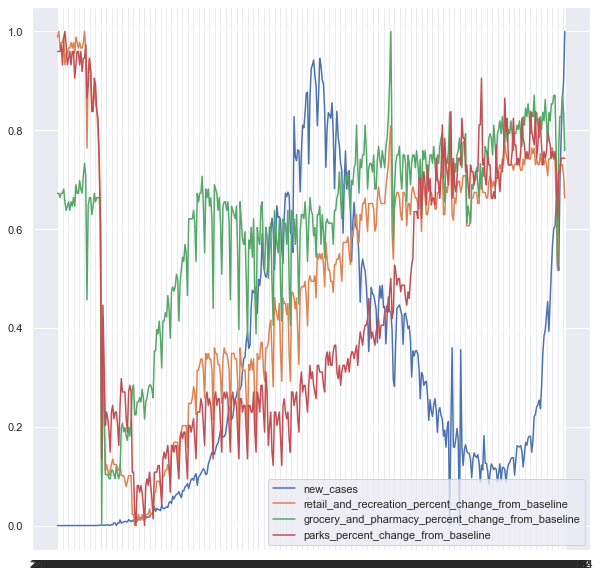

In [98]:
compare(mobility, ["new_cases","retail_and_recreation_percent_change_from_baseline",
                  "grocery_and_pharmacy_percent_change_from_baseline",
                  "parks_percent_change_from_baseline"])

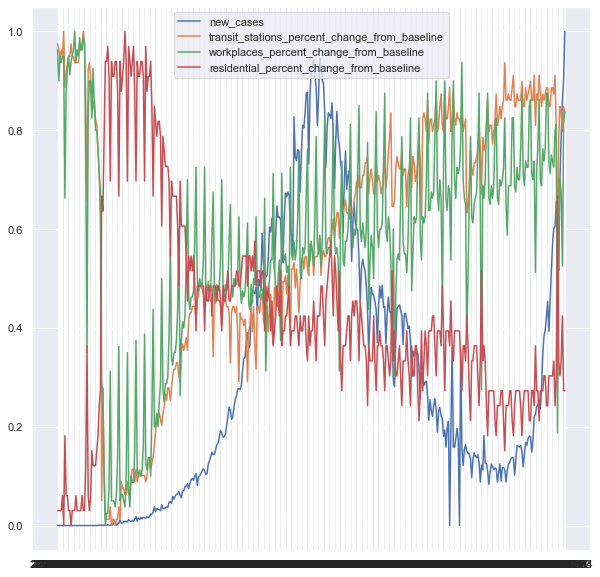

In [99]:
compare(mobility, ["new_cases","transit_stations_percent_change_from_baseline",
                  "workplaces_percent_change_from_baseline",
                  "residential_percent_change_from_baseline"])

In [101]:
X, y = sliding_window(mobility, 4)
# X_train = torch.from_numpy(X_train).float()
# y_train = torch.from_numpy(y_train).float()
X.shape, y.shape

((410, 128), (410,))

In [104]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
    print(train_index.shape, test_index.shape)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
(70,) (68,)
(138,) (68,)
(206,) (68,)
(274,) (68,)
(342,) (68,)


In [105]:
from sklearn.metrics import r2_score#(y_true, y_pred

In [ ]:
r2_score()

In [182]:
model = CoronaVirusPredictor(
  n_features=30, 
  n_hidden=50, 
  seq_len=4, 
  n_layers=2
)

from tqdm import tqdm_notebook

def train_model_with_crossval(
        model, 
        data, 
        labels,
        tscv,
    ):
    model = model.float()
    
    r2_scores, test_error_mse, test_error_mae = [], [], []
    train, test = {}, {}
    train['feats'], train['pred'], train['true'] = {}, {}, {}
    test['feats'], test['pred'], test['true'] = {}, {}, {}

    v = 0
    for train_index, test_index in tscv.split(data):
        v += 1
#         print(train_index.shape, test_index.shape)
        X_train, y_train = torch.from_numpy(data[train_index]), torch.from_numpy(labels[train_index])
        X_test, y_test = torch.from_numpy(data[test_index]), torch.from_numpy(labels[test_index])
        
        train['feats'][v] = X_train.numpy()
        test['feats'][v] = X_test.numpy()
#         print(X_train.shape, y_train.shape)
    
    
        loss_fn = torch.nn.L1Loss(reduction='sum')
        loss_fn2 = torch.nn.MSELoss(reduction='sum')

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
        num_epochs = 60

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in tqdm_notebook(range(num_epochs)):
            model.reset_hidden_state()

            y_pred = model(X_train.float()).squeeze()

            loss = loss_fn2(y_pred.float().flatten(), y_train.float())

            train_hist[t] = loss.item()

            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        with torch.no_grad():
            y_train_pred = model(X_train.float()).squeeze()

            train['pred'][v] = y_train_pred.numpy().tolist()
            train['true'][v] = y_train.numpy().tolist()
            
            y_test_pred = model(X_test.float()).squeeze()

            test['pred'][v] = y_test_pred.numpy().tolist()
            test['true'][v] = y_test.numpy().tolist()

            test_error_mae.append(loss_fn(y_test_pred.float(), y_test).item())
            test_error_mse.append(loss_fn2(y_test_pred.float(), y_test).item())
            r2_scores.append(r2_score(y_test.numpy(), y_test_pred.float().numpy()))
#     print(v)
                


    return r2_scores, test_error_mae, test_error_mse, train, test

X, y = sliding_window(mobility, 4)

r2_scores, test_error_mae, test_error_mse, train, test = train_model_with_crossval(
    model, 
    X, 
    y,
    tscv,
)

# def cross_val()

/Users/sharadchitlangia/miniconda3/envs/ca/lib/python3.6/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

/Users/sharadchitlangia/miniconda3/envs/ca/lib/python3.6/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

/Users/sharadchitlangia/miniconda3/envs/ca/lib/python3.6/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

/Users/sharadchitlangia/miniconda3/envs/ca/lib/python3.6/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

/Users/sharadchitlangia/miniconda3/envs/ca/lib/python3.6/site-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

In [183]:
r2_scores, test_error_mae, test_error_mse

([-2.0306818311711035,
  -1.0228176789086678,
  -1.4197923982135192,
  -4.059180715276677,
  -1.1325950011003187],
 [5.597932815551758,
  15.45898151397705,
  15.8331880569458,
  14.752965927124023,
  18.790870666503906],
 [0.7002300940783317,
  5.080651321493473,
  5.468932191066634,
  4.037150329708545,
  6.072485517686809])

In [154]:
train

{1: array([[0.00208753, 0.01692771, 0.01618817, ..., 0.10126582, 0.1125    ,
         0.87878788],
        [0.00221518, 0.01551787, 0.01574978, ..., 0.12658228, 0.1375    ,
         0.90909091],
        [0.00233917, 0.01507368, 0.01672619, ..., 0.12658228, 0.1375    ,
         0.90909091],
        ...,
        [0.04502614, 0.17885629, 0.19409403, ..., 0.44303797, 0.475     ,
         0.48484848],
        [0.04650687, 0.18000541, 0.19819127, ..., 0.44303797, 0.4875    ,
         0.51515152],
        [0.04802883, 0.18501709, 0.20162173, ..., 0.43037975, 0.575     ,
         0.45454545]]),
 2: array([[0.04968924, 0.20184824, 0.20715063, ..., 0.32911392, 0.65      ,
         0.45454545],
        [0.05149803, 0.21988644, 0.21361762, ..., 0.43037975, 0.4875    ,
         0.48484848],
        [0.05347197, 0.23996215, 0.22119591, ..., 0.44303797, 0.4625    ,
         0.48484848],
        ...,
        [0.32677632, 0.87518106, 0.8753629 , ..., 0.56962025, 0.5375    ,
         0.36363636],
      

In [145]:
test, pred

({1: [0.01678286564051063,
   0.017391220378918097,
   0.023117480059483577,
   0.02358098843160355,
   0.027095926920179998,
   0.03796906081616099,
   0.028611985553989073,
   0.0346375943915487,
   0.032484211746074666,
   0.032291083257691346,
   0.03006044921686398,
   0.04203441549662991,
   0.034830722879932025,
   0.03402923965314124,
   0.03633712508932193,
   0.03806562506035266,
   0.03656887927538192,
   0.04696884837482378,
   0.04876494331678866,
   0.044709245060738916,
   0.05935804090461384,
   0.053622124799629196,
   0.059850518549991315,
   0.06342339558508277,
   0.06401243747465189,
   0.06868614689352827,
   0.06193630622453119,
   0.05642248788118736,
   0.07042430328897817,
   0.07049189825991233,
   0.07826531991734101,
   0.08049595395816837,
   0.08480271924911645,
   0.07494350991714789,
   0.08517931980146393,
   0.09302033642982677,
   0.09549238108113328,
   0.09145599567392186,
   0.10079375808725546,
   0.1049073948898202,
   0.08151953494659998,
   0.

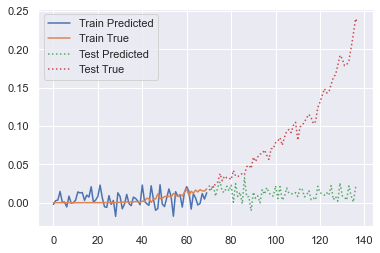

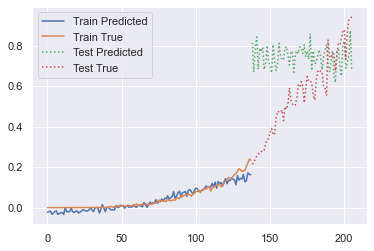

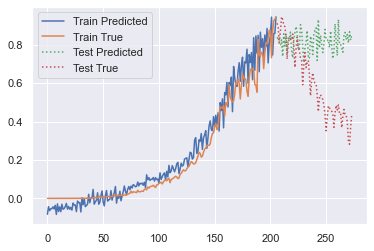

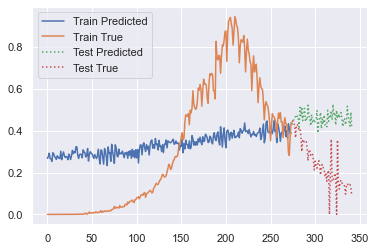

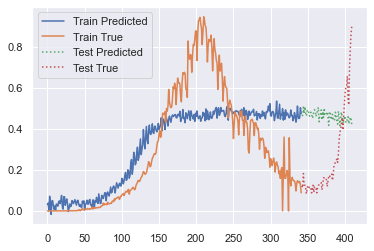

In [184]:
for i in range(1,6):
    plt.plot(list(range(0,len(train['pred'][i]))),train['pred'][i],label='Train Predicted')
    plt.plot(list(range(0,len(train['true'][i]))),train['true'][i],label='Train True')

    plt.plot(list(range(len(train['pred'][i]),len(train['pred'][i])+len(test['pred'][i]))),test['pred'][i],label='Test Predicted', linestyle='dotted')
    plt.plot(list(range(len(train['true'][i]),len(train['true'][i])+len(test['true'][i]))),test['true'][i],label='Test True', linestyle='dotted')
    
    plt.legend()
    plt.show()

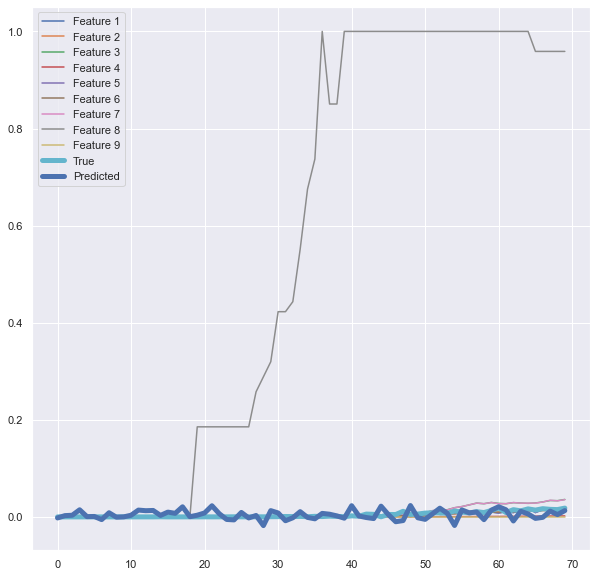

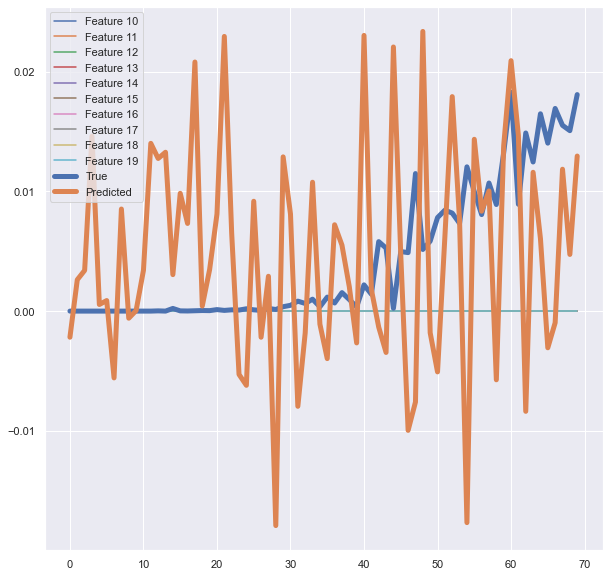

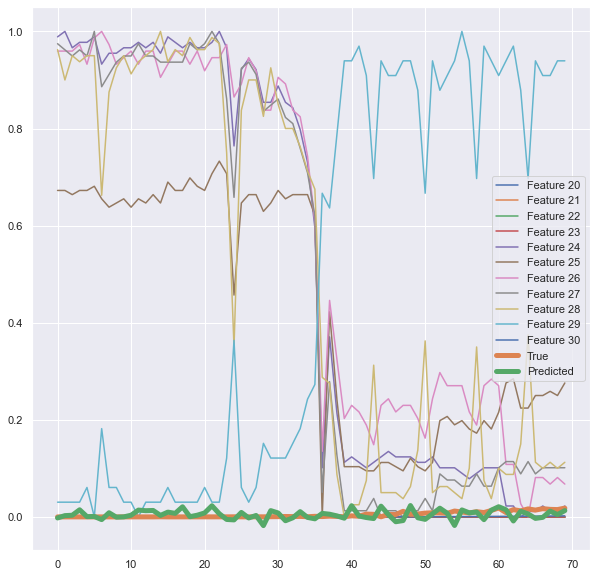

In [187]:
fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(1,10):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(10,20):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
v = 1
for i in range(20,31):  
    plt.plot(list(range(0,len(train['feats'][v]))),train['feats'][v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(train['true'][v]))),train['true'][v],label='True',linewidth=5)
plt.plot(list(range(0,len(train['pred'][v]))),train['pred'][v],label='Predicted',linewidth=5)

plt.legend()
plt.show()

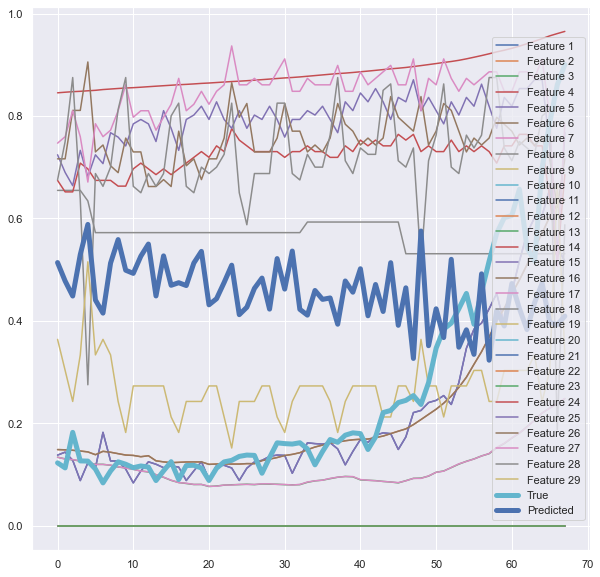

In [172]:
fig, ax = plt.subplots(figsize=(10,10))
v = 5
for i in range(1,30):  
    plt.plot(list(range(0,len(train[v]))),train[v][:,i],label=f'Feature {i}')
plt.plot(list(range(0,len(test[v]))),test[v],label='True',linewidth=5)
plt.plot(list(range(0,len(pred[v]))),pred[v],label='Predicted',linewidth=5)

plt.legend()
plt.show()